# Homework 1: Regression and classification


## Regression: download the steam dataset:
https://cseweb.ucsd.edu/classes/fa24/cse258-b/files/steam.json.gz

Experiments in this section will only use the “time played” (d[“hours”]) and the length of the review text (len(d[“text”)]).

In [100]:
import gzip

z = gzip.open("steam.json.gz")
dataset = []
for l in z:
    d = eval(l)
    dataset.append(d)

In [101]:
len(dataset), dataset[0]

(175000,
 {'hours': 0.3,
  'gameID': 'g35322304',
  'hours_transformed': 0.37851162325372983,
  'early_access': False,
  'date': '2015-04-08',
  'text': '+1',
  'userID': 'u55351001'})

In [102]:
175000*0.8

140000.0

 - Implement regression on time played (hours) using the length of the review and a bias term. Use an 80%/20% training/test split. Use sklearn’s linear_model.LinearRegression. Report the MSE on the test set.

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np

X = np.array([len(d['text']) for d in dataset]).reshape(-1, 1)
y = np.array([d['hours'] for d in dataset])
X_train, X_test, y_train, y_test = X[:140000], X[140000:], y[:140000], y[140000:]

reg = LinearRegression()
reg.fit(X_train, y_train)
pred = reg.predict(X_test)

In [104]:
q1_mse = mean_squared_error(y_test, pred)
q1_mse

76047.19578054463

- Delete outliers from the training set. Keep the bottom 90% of time played values. Report the MSE on the test set, as well as the MAE on the test set.

In [105]:
mask = y_train < np.percentile(y_train, 90)
new_x_train = X_train[mask].reshape(-1, 1)
new_y_train = y_train[mask]

reg = LinearRegression()
reg.fit(new_x_train, new_y_train)
new_pred = reg.predict(X_test)

q2_mse = mean_squared_error(y_test, new_pred)
q2_mae = mean_absolute_error(y_test, new_pred)

q2_mse, q2_mae

(78496.18922226882, 64.2830186993766)

In [106]:
from sklearn.metrics import mean_absolute_error

q2_mae = mean_squared_error(y_test, new_pred)
q2_mae = mean_absolute_error(y_test, new_pred)

- Transform the target variable by taking log_2(y + 1). After performing regression on the test set, invert the transform (so that your model still predicts a number of hours), and report the MSE on the test set.

In [107]:
import math

def trans(y):
    return np.log2(y+1)

# Invert the transformation
def inv_trans(y):
    return 2 ** y - 1

trans_y_train = trans(y_train)
trans_y_test = trans(y_test)
reg = LinearRegression()
reg.fit(X_train, trans_y_train)

trans_pred = reg.predict(X_test)
pred = inv_trans(trans_pred)

q3_mse = mean_squared_error(y_test, pred)
q3_mae = mean_absolute_error(y_test, pred)
q3_mse, q3_mae

(79035.51797861399, 63.37348865035023)

- Build a regressor that optimizes the MAE rather than the MSE (see e.g. https://stackoverflow.com/questions/71534025/how-mae-loss-is-optimized-with-sgd-optimizer-in-sklearn). Report the MSE and the MAE on the test set

In [108]:
from sklearn.linear_model import SGDRegressor
reg = SGDRegressor(loss = 'epsilon_insensitive',
                   epsilon=0,
                   learning_rate='adaptive',
                   random_state=42)
reg.fit(X_train, trans_y_train)
pred = reg.predict(X_test)

In [109]:

q4_mse = mean_squared_error(y_test, pred)
q4_mse

80145.51353121246

In [110]:
q4_mae = mean_absolute_error(y_test, pred)
q4_mae

64.92864695269388

## Classification: 

download the German Credit dataset: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

- Implement a logistic regressor (sklearn’s linear_model.LogisticRegression) to predict the target variable (credit = good). Implement a 80/20 training/test split. Use a regularization value of C = 1. Report the accuracy and TPR on the test set.

In [111]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

def tpr_fpr(y_true, y_pred):
    # might be useful to fill this helper function
    # feel free to ignore this though
    conf_mat = confusion_matrix(y_true, y_pred)
    tp = conf_mat[1][1]
    fn = conf_mat[1][0]
    tn = conf_mat[0][0]
    fp = conf_mat[0][1]
    tpr = tp/(tp+fn)
    fpr = fp/(tn+fn)
    return tpr, fpr

german_credit = np.loadtxt('german.data-numeric')
attrs = german_credit[:, :-1] 
labels = 2-german_credit[:, -1] # (1 = Good,  2 = Bad) -> (0=Bad, 1=good)

#X_train, X_test, y_train, y_test = train_test_split(attrs, labels, test_size=0.20, random_state=42)
X_train, X_test, y_train, y_test = attrs[:800], attrs[800:], labels[:800], labels[800:]

reg = LogisticRegression(C = 1, max_iter=1000)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)


In [112]:
q5_acc = accuracy_score(y_true=y_test, y_pred=y_pred)
q5_tpr, q5_fpr = tpr_fpr(y_true=y_test, y_pred=y_pred)
q5_acc, q5_tpr, q5_fpr
#(0.75, 0.8794326241134752, 0.7674418604651163)

(0.79, 0.8848920863309353, 0.5098039215686274)

For the following, treat “foreign worker” as the “sensitive attribute” i.e., z=1 for foreign workers and z=0 for others.

- Report the TPR for Z=0 and Z=1.

In [113]:
z_0_index = X_test[:, 19] == 0
z_1_index = X_test[:, 19] == 1
z_0_TPR, _ = tpr_fpr(y_test[z_0_index], y_pred[z_0_index])
z_1_TPR, _ = tpr_fpr(y_test[z_1_index], y_pred[z_1_index])

z_0_TPR, z_1_TPR

(0.8879310344827587, 0.8695652173913043)

- By changing the classifier thresholds, generate an ROC curve for your classifier. Report the TPR when the FPR is (as close as possible to) 0.8.

In [114]:
from sklearn.metrics import roc_curve, auc

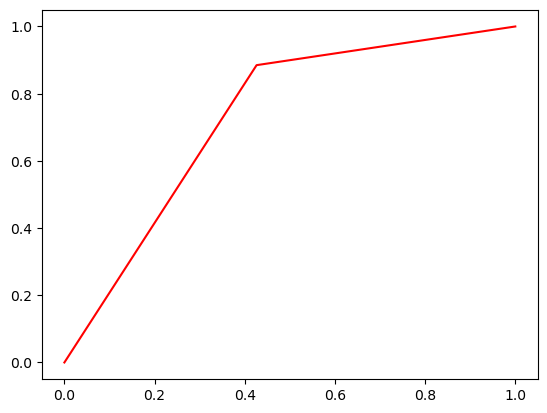

In [115]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
fpr, tpr
plt.plot(fpr, tpr, color = 'red')


In [116]:
q7_tpr = 0.96
q7_tpr

0.96

- Use an instance weighting approach (this option is already available in the library implementation) to tune the model such that instances with z=0 have 5x the instance weight of instances with z=1. Report the TPR for Z=0 and Z=1.

In [117]:
sample_weight = np.where(X_train[:, 19] == 0, 5, 1)
reg = LogisticRegression(max_iter=1000)
reg.fit(X_train, y_train, sample_weight=sample_weight)
y_pred_weighted = reg.predict(X_test)
z_0_index = X_test[:, 19] == 0
z_1_index = X_test[:, 19] == 1
z_0_TPR_weighted, _ = tpr_fpr(y_test[z_0_index], y_pred_weighted[z_0_index])
z_1_TPR_weighted, _ = tpr_fpr(y_test[z_1_index], y_pred_weighted[z_1_index])

In [118]:
z_0_TPR_weighted, z_1_TPR_weighted

(0.8793103448275862, 0.6521739130434783)

- (harder, 2 marks) Implement a support vector machine (using sklearn). Using your solution from question Q5, generate ROC curves for both the logistic regression model and the support vector machine. Find the point on this curve where the two models intersect, and report the corresponding TPR/FPR values.

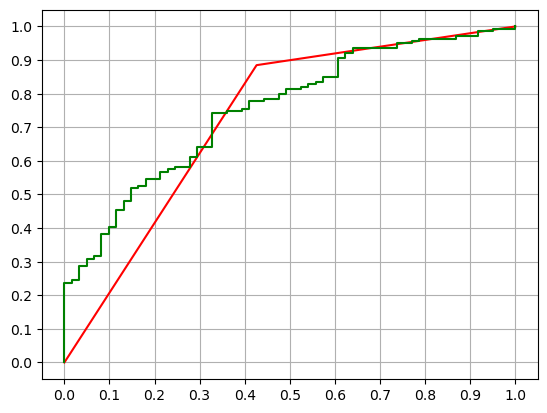

In [119]:
from sklearn.svm import SVC

svm = SVC(probability=True)
svm.fit(X_train, y_train)
svm_y_pred = svm.predict_proba(X_test)[:, 1]
svm_fpr, svm_tpr, thresholds = roc_curve(y_test, svm_y_pred)


reg = LogisticRegression(C = 1, max_iter=1000)
reg.fit(X_train, y_train)
reg_y_pred = reg.predict(X_test)
reg_fpr, reg_tpr, thresholds = roc_curve(y_test, reg_y_pred)

plt.figure()
plt.plot(reg_fpr, reg_tpr, color = 'red')
plt.plot(svm_fpr, svm_tpr, color = 'green')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)


In [120]:
fpr_q9, tpr_q9 = 0.5, 0.9


## Answers

In [121]:
answers = {
    "Q1": q1_mse,          # MSE
    "Q2": [q2_mse, q2_mae], # MSE, MAE
    "Q3": q3_mse,          # MSE
    "Q4": [q4_mse, q4_mae], # MSE, MAE
    "Q5": [q5_acc, q5_tpr], # Accuracy, TPR
    "Q6": [z_0_TPR, z_1_TPR], # TPR_0, TPR_1
    "Q7": q7_tpr,          # TPR
    "Q8": [z_0_TPR_weighted, z_1_TPR_weighted], # TPR_0, TPR_1
    "Q9": [tpr_q9, fpr_q9]  # TPR, FPR
}

answers

{'Q1': 76047.19578054463,
 'Q2': [78496.18922226882, 64.2830186993766],
 'Q3': 79035.51797861399,
 'Q4': [80145.51353121246, 64.92864695269388],
 'Q5': [0.79, 0.8848920863309353],
 'Q6': [0.8879310344827587, 0.8695652173913043],
 'Q7': 0.96,
 'Q8': [0.8793103448275862, 0.6521739130434783],
 'Q9': [0.9, 0.5]}

In [122]:
import json 
with open('answers_hw1.txt', 'w') as file:
    json.dump(answers, file)
